# Barycenter of MNIST Digits

In [1]:

from mmot import MMOTSolver

import numpy as np 
import matplotlib.pyplot as plt 
import itertools

## Download and open the MNIST dataset

In [2]:
import hashlib 
import os 
import requests 
import gzip

#fetch data (adapted from https://github.com/geohot/ai-notebooks/blob/master/mnist_from_scratch.ipynb)
path='./'
def fetch(url):
    fp = os.path.join(path, hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            data = f.read()
    else:
        with open(fp, "wb") as f:
            data = requests.get(url).content
            f.write(data)
    return np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()

digits = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
labels = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]

### Plot a few samples of the digit we're interested in

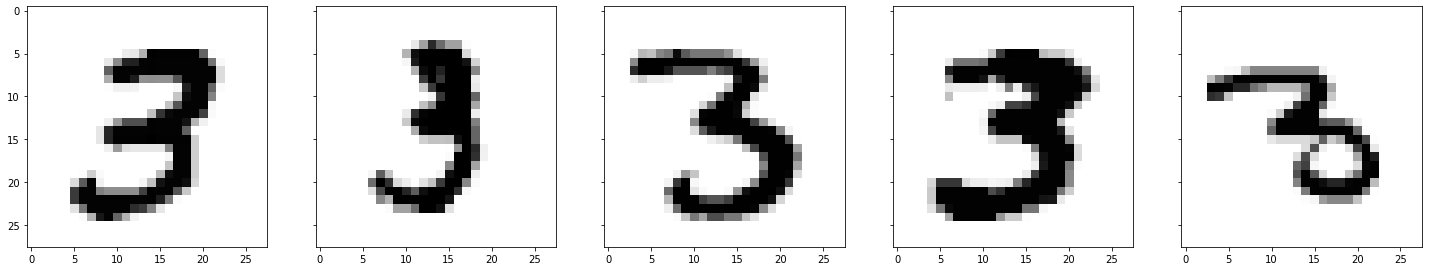

In [3]:
desired_digit = 3
inds = np.where(labels==desired_digit)[0]

num_plot = 5
fig,axs = plt.subplots(ncols=num_plot, sharey=True, figsize=(num_plot*5,5))
for i in range(num_plot):
    axs[i].imshow(digits[inds[i],:,:],cmap='Greys')


### Extract digits with similar total measure

In [4]:
# Grid of size n1 x n2
n1 = digits.shape[1]   # x axis
n2 = digits.shape[2]   # y axis

x, y = np.meshgrid(np.linspace(0.5/n1,1-0.5/n1,n1), np.linspace(0.5/n2,1-0.5/n1,n2))

In [5]:
unroll_node = 0

num_digits = 8 # Number of measures to include in barycenter calculation
sums = np.array([np.sum(digits[i,:,:]) for i in inds])

val = np.sum(digits[inds[0],:,:])

sorted_inds = inds[np.argsort(np.abs(sums-val))]
measures = [digits[sorted_inds[i],:,:]* (n1*n2/np.sum(digits[sorted_inds[i],:,:])) for i in range(num_digits)]

### Define the edge list for the barycenter problem

In [6]:

edge_list = []
for i in range(num_digits):
    for j in range(i+1,num_digits):
        edge_list += [[i,j]]

weights = np.ones(len(measures)) / len(measures)

prob = MMOTSolver(measures, edge_list, x, y, unroll_node, weights)

0


### Solve the problem

Iteration, StepSize,    Cost,   Error
        0,   0.0100,  -0.0014,   0.39550
       10,   0.0042,  0.0013,   0.04827
       20,   0.0024,  0.0014,   0.01882
       30,   0.0018,  0.0015,   0.01747
       40,   0.0013,  0.0016,   0.01482
       50,   0.0013,  0.0017,   0.01493
       60,   0.0003,  0.0017,   0.01551
       70,   0.0004,  0.0017,   0.01487
       80,   0.0006,  0.0018,   0.01450
       90,   0.0001,  0.0018,   0.01512
      100,   0.0002,  0.0018,   0.01520
      110,   0.0002,  0.0018,   0.01484
      120,   0.0001,  0.0018,   0.01514
      130,   0.0001,  0.0018,   0.01504
      140,   0.0001,  0.0018,   0.01515
      150,   0.0000,  0.0018,   0.01561
      160,   0.0000,  0.0018,   0.01565
      170,   0.0000,  0.0018,   0.01514


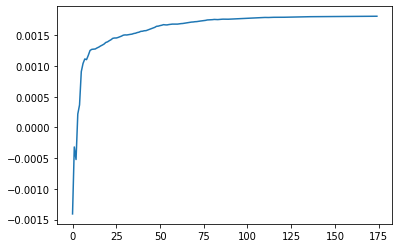

In [7]:
dual_vars = [np.zeros(x.shape) for i in range(prob.NumDual())]

num_its = 10000
step_size = 0.01
ftol = 1e-9
gtol = 1e-3

root_node = 4
costs = np.nan*np.zeros(num_its)

root_nodes = np.arange(prob.NumDual())
root_cycler = itertools.cycle(root_nodes)

print('Iteration, StepSize,    Cost,   Error')
for i in range(num_its):
    error = prob.Step(next(root_cycler), dual_vars, step_size)
    
    costs[i] = prob.ComputeCost(dual_vars)
    if(i>0):
        step_size = prob.StepSizeUpdate(step_size, costs[i], costs[i-1], error)

    if((i%10)==0):
        print('{:9d},   {:0.4f},  {:0.4f},   {:0.5f}'.format(i,step_size, costs[i], error))

    # Check for convergence in cost
    if(np.abs(costs[i]-costs[i-1])<ftol):
        break

    # Check for convergence via gradient 
    if(error<gtol):
        break 
    
plt.plot(costs)
plt.show()

### Compute the Barycenter

In [8]:
weights = np.ones(num_digits)/num_digits
bary = prob.Barycenter(dual_vars)

### Plot the images used and the barycenter

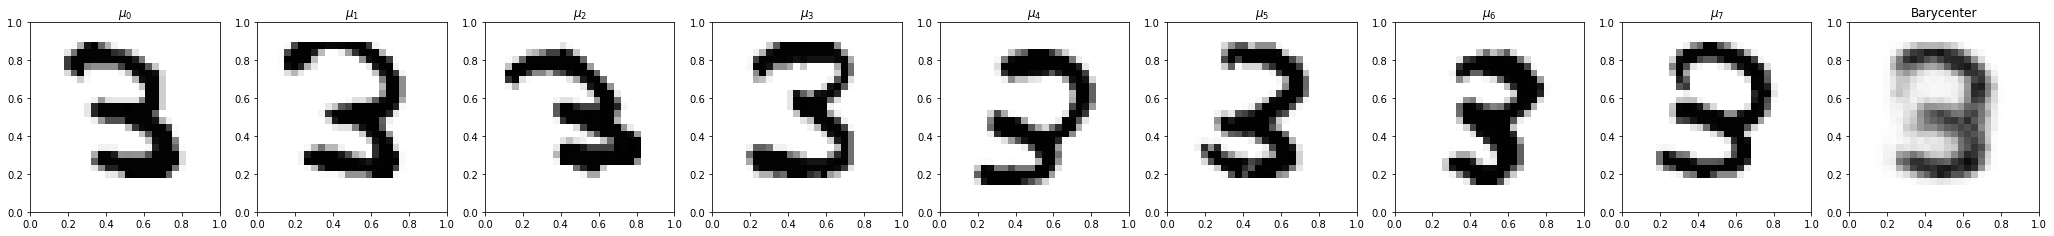

In [9]:
vmax = np.max([np.max(m) for m in measures])
fig, axs = plt.subplots(1, num_digits+1, figsize=((num_digits+1)*4,4))
for i in range(num_digits):
    axs[i].imshow(measures[i], origin='lower', extent=(0,1,0,1), vmin=0, vmax=vmax, cmap='Greys')
    axs[i].set_title("$\\mu_{{ {:0d} }}$".format(i))
    
axs[-1].imshow(bary, origin='lower', extent=(0,1,0,1), vmin=0, vmax=vmax, cmap='Greys')
axs[-1].set_title('Barycenter')
plt.show()